In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statistics import stdev, pstdev
plt.style.use('seaborn-whitegrid')
import scipy.optimize
from scipy import signal

In [2]:
lung_onda = 650e-09
L = 0.99

In [3]:
df = pd.read_csv('Capstone_Data.csv',delimiter=',')
n = df.shape[1] #number of columns

set_names = []
k = 0
d = {}
for i in range(0,n,2):
    set_names.append(df.columns[::][i].rpartition(' ')[2])
    #print(set_names[k])
    d[set_names[k]] = df.iloc[:,i:i+2].dropna()
    k +=1

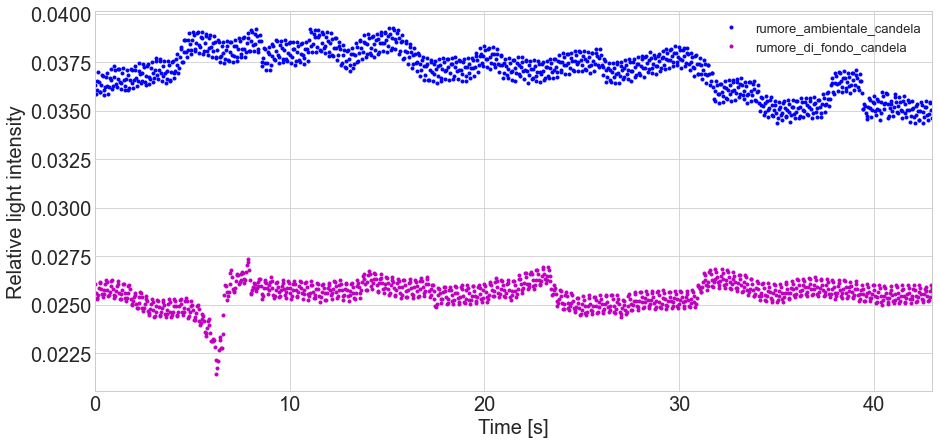

In [4]:
fig, ax = plt.subplots(figsize=(15, 7))

plt.errorbar(d['rumore_ambientale_candela'].iloc[:,0], d['rumore_ambientale_candela'].iloc[:,1],
             linestyle = None, fmt='.b', label='rumore_ambientale_candela');
plt.errorbar(d['rumore_di_fondo_candela'].iloc[:,0], d['rumore_di_fondo_candela'].iloc[:,1],
             linestyle = None, fmt='.m', label='rumore_di_fondo_candela');

plt.xlabel('Time [s]', fontsize =20)
ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
plt.ylabel('Relative light intensity', fontsize = 20)
plt.xticks(np.arange(0, 55, step=10))
plt.legend(loc=1, prop={'size': 13});
plt.xlim(0, 43)

plt.show()

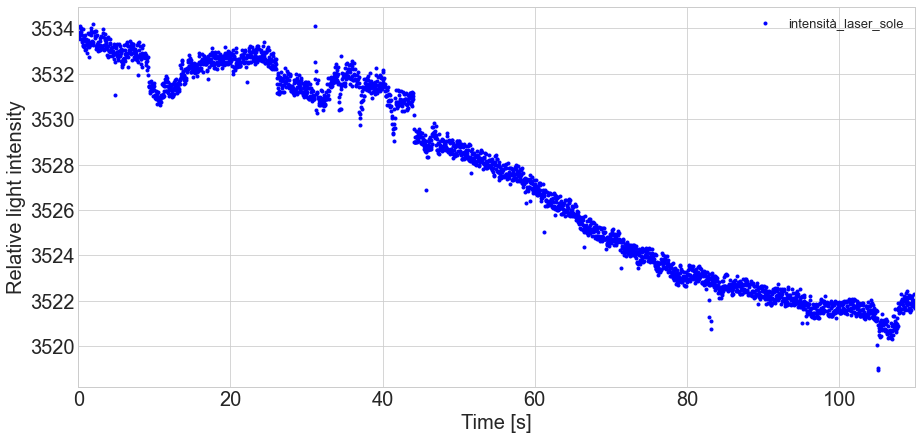

In [5]:
fig, ax = plt.subplots(figsize=(15, 7))

plt.errorbar(d['intensità_laser_sole'].iloc[:,0], d['intensità_laser_sole'].iloc[:,1],
             linestyle = None, fmt='.b', label='intensità_laser_sole');
plt.xlabel('Time [s]', fontsize =20)
ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
plt.ylabel('Relative light intensity', fontsize = 20)
plt.legend(loc=1, prop={'size': 13});
plt.xlim(0, 110)
plt.show()

In [6]:
#sottriamo la media del rumore ambientale
threshold = d['rumore_abientale_1.5_candela'].iloc[:,1].mean() 

In [7]:
def preprocessing(Table, threshold, manual_adj = 0):
    Idata = Table.iloc[:,0].values - threshold
    xdata = Table.iloc[:,1].values

    MaxIntensity = np.max(Idata)
    maxint = np.argmax(Idata)
    xdata = (xdata-xdata[maxint]+manual_adj) #trasla    

    xdata1 = []
    Idata1 = []
    for i in range(len(Idata)):
        if(xdata[i] != 0):
            xdata1.append(xdata[i])
            Idata1.append(Idata[i])
    #errors        
    xdataerr = np.ones(len(xdata1))*8e-6 #secondo il manuale
    Idataerr1 = np.ones(len(xdata1))*stdev(d['intensità_laser_sole'].iloc[:,1]/100)*3 #manuale

    return np.array(Idata1), np.array(xdata1), MaxIntensity, np.array(xdataerr), np.array(Idataerr1)

In [8]:
def estimate(xdata, Idata, grafico = True, manual_sel = [1,2]):
    maxint = np.max(Idata) #maximum value of intensity
    #print(maxint)
    index_max = np.argmax(Idata) #index 
    #print(index_max)
    inv_data1 = 1/Idata[:index_max] # inverse  (in order to find minima)
    inv_data2 = 1/Idata[index_max:] # inverse  (in order to find minima)

    min_peakind1 = signal.find_peaks_cwt(inv_data1, np.arange(1,10)) # builtin function fo find (min) peaks, so we can take the one closest to the maximum
    min_peakind2 = index_max + signal.find_peaks_cwt(inv_data2, np.arange(1,10)) # builtin function fo find (min) peaks, so we can take the one closest to the maximum
    s1 = list(np.abs(xdata[min_peakind1] - xdata[index_max])) # used to convert any of the list/tuple to the distinct element and sorted sequence of elements
    s2 = list(np.abs(xdata[min_peakind2] - xdata[index_max])) # used to convert any of the list/tuple to the distinct element and sorted sequence of elements
    c1 = min_peakind1[s1.index(sorted(s1)[manual_sel[0]])]
    c2 = min_peakind2[s2.index(sorted(s2)[manual_sel[1]])]

    l1 = abs(xdata[index_max] - xdata[c1])
    l2 = abs(xdata[index_max] - xdata[c2])
    est1 = (lung_onda*L)/l1
    est2 = (lung_onda*L)/l2
    #print(("estimate 1 = %g")%(est1))
    #print(("estimate 2 = %g")%(est2))
    
    if grafico == True:
        fig, ax = plt.subplots(figsize=(15, 7))
        plt.errorbar(xdata,Idata,xerr = None,marker='.');
        plt.plot(xdata[index_max], Idata[index_max],marker='o', color = 'r')
        plt.plot(xdata[c1], Idata[c1],marker='o', color = 'r')
        plt.plot(xdata[c2], Idata[c2],marker='o', color = 'r')
        plt.xlabel('Posizione [m]', fontsize =20)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
        plt.ylabel('Relative light intensity', fontsize = 20)
        plt.show()
    
    return est1, est2

In [9]:
def distanceFunctionFit(x,b,intensity):
    return intensity*((np.sin(np.pi*b*(x/L)/lung_onda))/(np.pi*b*(x/L)/lung_onda))**2

def fitting(b,MaxIntensity,xdata,Idata,Idataerr, double = False):
    #simulation
    #x = np.linspace(min(xdata),max(xdata),1000)
    #y = distanceFunctionFit(x,b,MaxIntensity)
    if double ==True:
        popt, pcov = scipy.optimize.curve_fit(distanceFunctionFit, xdata, Idata,sigma = Idataerr, p0 = (b,MaxIntensity))

    popt, pcov = scipy.optimize.curve_fit(distanceFunctionFit, xdata, Idata,sigma = Idataerr, p0 = (b,MaxIntensity))
    bfit,intensity = popt #variabili
    bfiterr, intensityerr = np.sqrt(np.diag(pcov)) #errori
    
    xfitb = np.linspace(min(xdata), max(xdata), 1000)
    yfitb = distanceFunctionFit(xfitb,bfit,intensity)
    return xfitb, yfitb,bfit, bfiterr, intensity,intensityerr

#### Fenditura 0.16

a (initial estimate) = 0.00014564 +- 9.24887e-05
MaxIntensity = 38.4317 +- 6.56064
bfit1 = 0.000155545 +- 6.77718e-07
bfit2 = 0.000147471 +- 2.06909e-06
bfit3 = 0.000147086 +- 1.79222e-06
bfit4 = 0.000160405 +- 2.0362e-06
bfit5 = 0.000154108 +- 2.23573e-06
bfit6 = 0.000165325 +- 1.09773e-06

-- final estimates for 0.16:
a = 0.00015499 +- 2.14756e-05
max intensity = 34.4852 +- 6.50661


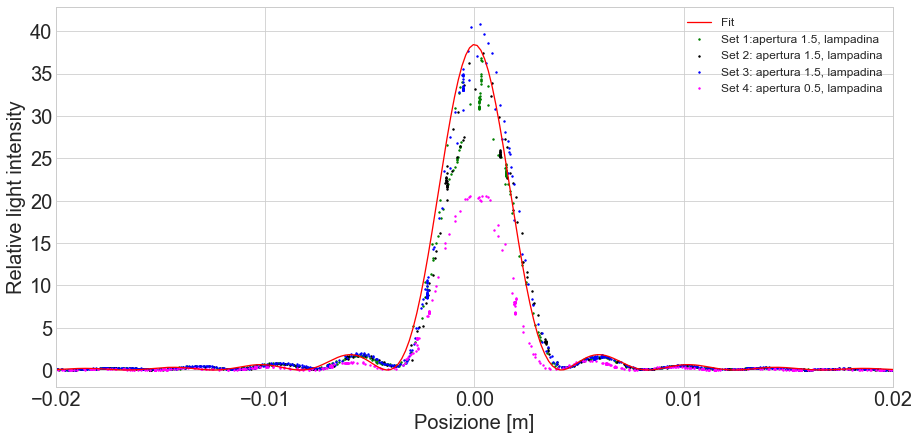

In [10]:
#tolgo già qui gli zeri
Table1 = d['Antonio_0.16_1.5_lampadina'].loc[((d['Antonio_0.16_1.5_lampadina'].iloc[:,1] != 0) )]
Table2 = d['Alessio_0.16_1.5_lampadina'].loc[((d['Alessio_0.16_1.5_lampadina'].iloc[:,1] != 0) )]
Table3 = d['Alessandra_0.16_1.5_lampadina'].loc[((d['Alessandra_0.16_1.5_lampadina'].iloc[:,1] != 0) )]
Table4 = d['Alessio_0.16_0.5_lampadina'].loc[((d['Alessio_0.16_0.5_lampadina'].iloc[:,1] != 0) )]


Idata1, xdata1, MaxIntensity, xdataerr, Idataerr1 = preprocessing(Table1, threshold, manual_adj = 0)
Idata2, xdata2, MaxIntensity2, xdataerr2, Idataerr2 = preprocessing(Table2, threshold, manual_adj = 0)
Idata3, xdata3, MaxIntensity3, xdataerr3, Idataerr3 = preprocessing(Table3, threshold, manual_adj = 0)
Idata4, xdata4, MaxIntensity4, xdataerr4, Idataerr4 = preprocessing(Table4, threshold, manual_adj = 0)

#Stima di a
est11,est12 = estimate(xdata1, Idata1, grafico = False,manual_sel = [1,2])
est21,est22 = estimate(xdata2, Idata2, grafico = False,manual_sel = [1,1])
est31,est32 = estimate(xdata3, Idata3, grafico = False,manual_sel = [0,1])
a_est_1 = (est11+est21+est31+est12+est22+est32)/6
a_est_1_err = stdev([est11,est21,est31,est12,est22,est32])*3
print(("a (initial estimate) = %g +- %g")%(a_est_1, a_est_1_err))

#Stima intensità massima
MaxIntensity_est = (MaxIntensity+MaxIntensity2+MaxIntensity3)/3
MaxIntensity_est_err = stdev([MaxIntensity,MaxIntensity2,MaxIntensity3])*3
print(("MaxIntensity = %g +- %g")%(MaxIntensity_est, MaxIntensity_est_err))

#fit
xfitb1, yfitb1, bfit1, bfiterr1, intensity1, intensity_err_1 = fitting(est11,MaxIntensity_est,xdata1[:1000],Idata1[:1000],Idataerr1[:1000])
print(("bfit1 = %g +- %g")%(bfit1, bfiterr1*3))
xfitb2, yfitb2, bfit2, bfiterr2, intensity2, intensity_err_2 = fitting(est21,MaxIntensity_est,xdata2[:1200],Idata2[:1200],Idataerr2[:1200])
print(("bfit2 = %g +- %g")%(bfit2, bfiterr2*3))
xfitb3, yfitb3, bfit3, bfiterr3, intensity3, intensity_err_3 = fitting(est31,MaxIntensity_est,xdata3[:1500],Idata3[:1500],Idataerr3[:1500])
print(("bfit3 = %g +- %g")%(bfit3, bfiterr3*3))

xfitb11, yfitb11, bfit11, bfiterr11, intensity11, intensity_err_11 = fitting(est11,MaxIntensity_est,xdata1[1000:],Idata1[1000:],Idataerr1[1000:])
print(("bfit4 = %g +- %g")%(bfit11, bfiterr11*3))
xfitb22, yfitb22, bfit22, bfiterr22, intensity22, intensity_err_22 = fitting(est22,MaxIntensity_est,xdata2[1200:],Idata2[1200:],Idataerr2[1200:])
print(("bfit5 = %g +- %g")%(bfit22, bfiterr22*3))
xfitb33, yfitb33, bfit33, bfiterr33, intensity33, intensity_err_33 = fitting(est32,MaxIntensity_est,xdata3[1500:],Idata3[1500:],Idataerr3[1500:])
print(("bfit6 = %g +- %g")%(bfit33, bfiterr33*3))

b_fit_est_1 = (bfit11+bfit22+bfit33+bfit1+bfit2+bfit3)/6
b_fit_est_err_1 = stdev([bfit11,bfit22,bfit33,bfit1,bfit2,bfit3])*3
print('')
int_fit_est_1 = (intensity11+intensity22+intensity33+intensity1+intensity2+intensity3)/6
int_fit_est_err_1 = stdev([intensity11,intensity22,intensity33,intensity1,intensity2,intensity3])*3
print(("-- final estimates for 0.16:"))
print(("a = %g +- %g")%(b_fit_est_1, b_fit_est_err_1))
print(("max intensity = %g +- %g")%(int_fit_est_1, int_fit_est_err_1))

xfitb_1 = np.linspace(min(xdata1), max(xdata1), 1000)
yfitb_1 = distanceFunctionFit(xfitb_1,b_fit_est_1,MaxIntensity_est)

#grafici
fig, ax = plt.subplots(figsize=(15, 7))
plt.scatter(xdata1,Idata1,linestyle = "None", color = 'green', s = 2,label='Set 1:apertura 1.5, lampadina');
plt.scatter(xdata2,Idata2,linestyle = "None",color= 'black', s = 2,label='Set 2: apertura 1.5, lampadina');
plt.scatter(xdata3,Idata3,linestyle = "None", color= 'blue', s = 2,label='Set 3: apertura 1.5, lampadina');
plt.scatter(xdata4,Idata4,linestyle = "None", color= 'magenta', s = 2,label='Set 4: apertura 0.5, lampadina');
#plt.plot(np.zeros(len(yfitb_1)),yfitb_1, color = 'red')
plt.plot(xfitb_1,yfitb_1, color = 'red',linewidth=1.3, label = 'Fit')

plt.xlabel('Posizione [m]', fontsize =20)
ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
plt.ylabel('Relative light intensity', fontsize = 20)
plt.legend(loc=1, prop={'size': 12});
plt.xlim(-0.02, 0.02)
plt.xticks(np.arange(-0.02, 0.025, step=0.01))
plt.show()

#### Fenditura 0.08

a (initial estimate) = 8.12441e-05 +- 2.01807e-05
MaxIntensity = 16.8704 +- 0.88116
bfit1 = 7.71092e-05 +- 3.64977e-07
bfit2 = 8.07314e-05 +- 1.82105e-07
bfit3 = 8.02345e-05 +- 2.19213e-07
bfit4 = 7.97338e-05 +- 5.19731e-07
bfit5 = 7.96843e-05 +- 3.46107e-07
bfit6 = 7.93547e-05 +- 1.88266e-07

-- final estimates for 0.08:
a = 7.94746e-05 +- 3.76561e-06
max intensity = 16.6125 +- 1.08154


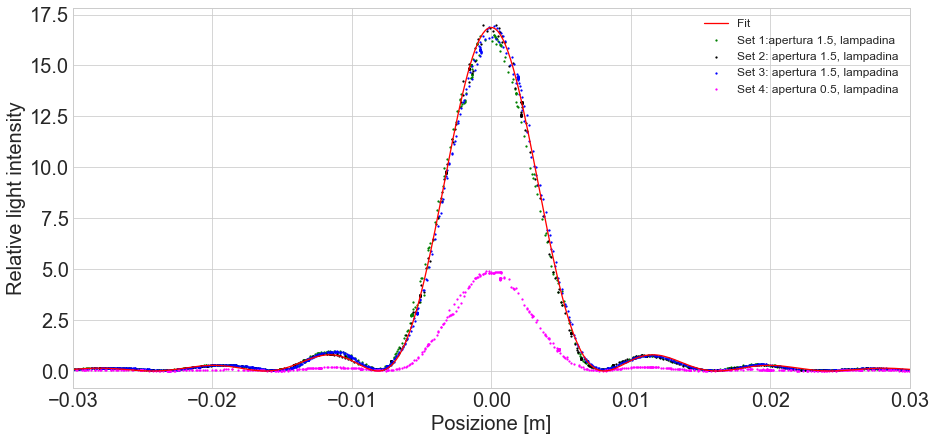

In [11]:
#tolgo già qui gli zeri
Table1 = d['Antonio_0.08_1.5_lampadina'].loc[((d['Antonio_0.08_1.5_lampadina'].iloc[:,1] != 0) )]
Table2 = d['Alessio_0.08_1.5_lampadina'].loc[((d['Alessio_0.08_1.5_lampadina'].iloc[:,1] != 0) )]
Table3 = d['Alessandra_0.08_1.5_lampadina'].loc[((d['Alessandra_0.08_1.5_lampadina'].iloc[:,1] != 0) )]
Table4 = d['Antonio_0.08_0.5_lampadina'].loc[((d['Antonio_0.08_0.5_lampadina'].iloc[:,1] != 0) )]

Idata1, xdata1, MaxIntensity, xdataerr, Idataerr1 = preprocessing(Table1, threshold, manual_adj = 0)
Idata2, xdata2, MaxIntensity2, xdataerr2, Idataerr2 = preprocessing(Table2, threshold, manual_adj = 0)
Idata3, xdata3, MaxIntensity3, xdataerr3, Idataerr3 = preprocessing(Table3, threshold, manual_adj = 0)
Idata4, xdata4, MaxIntensity4, xdataerr4, Idataerr4 = preprocessing(Table4, threshold, manual_adj = -0.0004)

#Stima di a
est11,est12 = estimate(xdata1, Idata1, grafico = False,manual_sel = [1,2])
est21,est22 = estimate(xdata2, Idata2, grafico = False,manual_sel = [2,3])
est31,est32 = estimate(xdata3, Idata3, grafico = False,manual_sel = [2,3])
a_est_1 = (est11+est21+est31+est12+est22+est32)/6
a_est_1_err = stdev([est11,est21,est31,est12,est22,est32])*3
print(("a (initial estimate) = %g +- %g")%(a_est_1, a_est_1_err))

#Stima intensità massima
MaxIntensity_est = (MaxIntensity+MaxIntensity2+MaxIntensity3)/3
MaxIntensity_est_err = stdev([MaxIntensity,MaxIntensity2,MaxIntensity3])*3
print(("MaxIntensity = %g +- %g")%(MaxIntensity_est, MaxIntensity_est_err))

#fit
xfitb1, yfitb1, bfit1, bfiterr1, intensity1, intensity_err_1 = fitting(est11,MaxIntensity_est,xdata1[:1000],Idata1[:1000],Idataerr1[:1000])
print(("bfit1 = %g +- %g")%(bfit1, bfiterr1*3))
xfitb2, yfitb2, bfit2, bfiterr2, intensity2, intensity_err_2 = fitting(est21,MaxIntensity_est,xdata2[:1300],Idata2[:1300],Idataerr2[:1300])
print(("bfit2 = %g +- %g")%(bfit2, bfiterr2*3))
xfitb3, yfitb3, bfit3, bfiterr3, intensity3, intensity_err_3 = fitting(est31,MaxIntensity_est,xdata3[:1450],Idata3[:1450],Idataerr3[:1450])
print(("bfit3 = %g +- %g")%(bfit3, bfiterr3*3))

xfitb11, yfitb11, bfit11, bfiterr11, intensity11, intensity_err_11 = fitting(est12,MaxIntensity_est,xdata1[1000:],Idata1[1000:],Idataerr1[1000:])
print(("bfit4 = %g +- %g")%(bfit11, bfiterr11*3))
xfitb22, yfitb22, bfit22, bfiterr22, intensity22, intensity_err_22 = fitting(est22,MaxIntensity_est,xdata2[1300:],Idata2[1300:],Idataerr2[1300:])
print(("bfit5 = %g +- %g")%(bfit22, bfiterr22*3))
xfitb33, yfitb33, bfit33, bfiterr33, intensity33, intensity_err_33 = fitting(est32,MaxIntensity_est,xdata3[1450:],Idata3[1450:],Idataerr3[1450:])
print(("bfit6 = %g +- %g")%(bfit33, bfiterr33*3))

b_fit_est_1 = (bfit11+bfit22+bfit33+bfit1+bfit2+bfit3)/6
b_fit_est_err_1 = stdev([bfit11,bfit22,bfit33,bfit1,bfit2,bfit3])*3
print('')
int_fit_est_1 = (intensity11+intensity22+intensity33+intensity1+intensity2+intensity3)/6
int_fit_est_err_1 = stdev([intensity11,intensity22,intensity33,intensity1,intensity2,intensity3])*3
print(("-- final estimates for 0.08:"))
print(("a = %g +- %g")%(b_fit_est_1, b_fit_est_err_1))
print(("max intensity = %g +- %g")%(int_fit_est_1, int_fit_est_err_1))


xfitb_1 = np.linspace(min(xdata1), max(xdata1), 1000)
yfitb_1 = distanceFunctionFit(xfitb_1,b_fit_est_1,MaxIntensity_est)

#grafici
fig, ax = plt.subplots(figsize=(15, 7))
plt.scatter(xdata1,Idata1,linestyle = "None", color = 'green', s = 1.5,label='Set 1:apertura 1.5, lampadina');
plt.scatter(xdata2,Idata2,linestyle = "None",color= 'black', s = 1.5,label='Set 2: apertura 1.5, lampadina');
plt.scatter(xdata3,Idata3,linestyle = "None", color= 'blue', s = 1.5,label='Set 3: apertura 1.5, lampadina');
plt.scatter(xdata4,Idata4,linestyle = "None", color= 'magenta', s = 1.5,label='Set 4: apertura 0.5, lampadina');
#plt.plot(np.zeros(len(yfitb_1)),yfitb_1, color = 'red')
plt.plot(xfitb_1,yfitb_1, color = 'red',linewidth=1.3, label = 'Fit')

plt.xlabel('Posizione [m]', fontsize =20)
ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
plt.ylabel('Relative light intensity', fontsize = 20)
plt.legend(loc=1, prop={'size': 12});
plt.xlim(-0.03, 0.03)
plt.xticks(np.arange(-0.03, 0.035, step=0.01))
plt.show()

#### Fenditura 0.04

a = 4.504e-05 +- 2.36075e-05
MaxIntensity = 4.38388 +- 0.237944
bfit1 = 4.14836e-05 +- 3.5258e-07
bfit2 = 4.42041e-05 +- 1.95881e-07
bfit3 = 4.36862e-05 +- 2.90394e-07
bfit4 = 4.07642e-05 +- 3.55292e-07
bfit5 = 4.44209e-05 +- 2.32021e-07
bfit6 = 4.33589e-05 +- 2.90103e-07

-- final estimates for 0.04:
a = 4.29863e-05 +- 4.52306e-06
max intensity = 4.2407 +- 0.25194


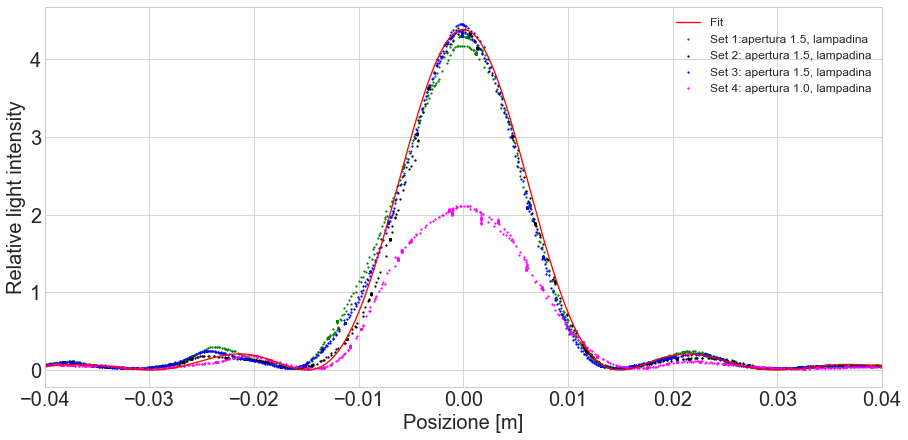

In [12]:
#tolgo già qui gli zeri
Table1 = d['Antonio_0.04_1.5_lampadina'].loc[((d['Antonio_0.04_1.5_lampadina'].iloc[:,1] != 0) )]
Table2 = d['Alessio_0.04_1.5_lampadina'].loc[((d['Alessio_0.04_1.5_lampadina'].iloc[:,1] != 0) )]
Table3 = d['Alessandra_0.04_1.5_lampadina'].loc[((d['Alessandra_0.04_1.5_lampadina'].iloc[:,1] != 0) )]
Table4 = d['Alessio_0.04_1.0_lampada'].loc[((d['Alessio_0.04_1.0_lampada'].iloc[:,1] != 0) )]

Idata1, xdata1, MaxIntensity1, xdataerr1, Idataerr1 = preprocessing(Table1, threshold, manual_adj = -0.0002)
Idata2, xdata2, MaxIntensity2, xdataerr2, Idataerr2 = preprocessing(Table2, threshold, manual_adj = -0.0005)
Idata3, xdata3, MaxIntensity3, xdataerr3, Idataerr3 = preprocessing(Table3, threshold, manual_adj = -0.0002)
Idata4, xdata4, MaxIntensity4, xdataerr4, Idataerr4 = preprocessing(Table4, threshold, manual_adj = -0.0002)

#Calcolo stima di a
est11,est12 = estimate(xdata1, Idata1, grafico = False,manual_sel = [3,8])
est21,est22 = estimate(xdata2, Idata2, grafico = False,manual_sel = [4,5])
est31,est32 = estimate(xdata3, Idata3, grafico = False,manual_sel = [2,6])

a_est_2 = (est11+est21+est31+est12+est22+est32)/6
a_est_err_2 = stdev([est11,est21,est31,est12,est22,est32])*3
print(("a = %g +- %g")%(a_est_2, a_est_err_2))


#Stima intensità massima
MaxIntensity_est = (MaxIntensity1+MaxIntensity2+MaxIntensity3)/3
MaxIntensity_est_err = stdev([MaxIntensity1,MaxIntensity2,MaxIntensity3])*3
print(("MaxIntensity = %g +- %g")%(MaxIntensity_est, MaxIntensity_est_err))


#fit
xfitb1, yfitb1, bfit1, bfiterr1, intensity1, intensity_err_1 = fitting(est11,MaxIntensity_est,xdata1[:1000],Idata1[:1000],Idataerr1[:1000])
print(("bfit1 = %g +- %g")%(bfit1, bfiterr1*3))
xfitb2, yfitb2, bfit2, bfiterr2, intensity2, intensity_err_2 = fitting(est21,MaxIntensity_est,xdata2[:1000],Idata2[:1000],Idataerr2[:1000])
print(("bfit2 = %g +- %g")%(bfit2, bfiterr2*3))
xfitb3, yfitb3, bfit3, bfiterr3, intensity3, intensity_err_3 = fitting(est31,MaxIntensity_est,xdata3[:1000],Idata3[:1000],Idataerr3[:1000])
print(("bfit3 = %g +- %g")%(bfit3, bfiterr3*3))

xfitb11, yfitb11, bfit11, bfiterr11, intensity11, intensity_err_11 = fitting(est12,MaxIntensity_est,xdata1[1000:],Idata1[1000:],Idataerr1[1000:])
print(("bfit4 = %g +- %g")%(bfit11, bfiterr11*3))
xfitb22, yfitb22, bfit22, bfiterr22, intensity22, intensity_err_22 = fitting(est22,MaxIntensity_est,xdata2[1000:],Idata2[1000:],Idataerr2[1000:])
print(("bfit5 = %g +- %g")%(bfit22, bfiterr22*3))
xfitb33, yfitb33, bfit33, bfiterr33, intensity33, intensity_err_33 = fitting(est32,MaxIntensity_est,xdata3[1000:],Idata3[1000:],Idataerr3[1000:])
print(("bfit6 = %g +- %g")%(bfit33, bfiterr33*3))

b_fit_est_2 = (bfit11+bfit22+bfit33+bfit1+bfit2+bfit3)/6
b_fit_est_err_2 = stdev([bfit11,bfit22,bfit33,bfit1,bfit2,bfit3])*3
print('')
int_fit_est_2 = (intensity11+intensity22+intensity33+intensity1+intensity2+intensity3)/6
int_fit_est_err_2 = stdev([intensity11,intensity22,intensity33,intensity1,intensity2,intensity3])*3
print(("-- final estimates for 0.04:"))
print(("a = %g +- %g")%(b_fit_est_2, b_fit_est_err_2))
print(("max intensity = %g +- %g")%(int_fit_est_2, int_fit_est_err_2))


xfitb_2 = np.linspace(min(xdata2), max(xdata2), 1000)
yfitb_2 = distanceFunctionFit(xfitb_2,b_fit_est_2,MaxIntensity_est)

#grafici
fig, ax = plt.subplots(figsize=(15, 7))
plt.scatter(xdata1,Idata1,linestyle = "None", color = 'green', s = 1.5,label='Set 1:apertura 1.5, lampadina');
plt.scatter(xdata2,Idata2,linestyle = "None",color= 'black', s = 1.5,label='Set 2: apertura 1.5, lampadina');
plt.scatter(xdata3,Idata3,linestyle = "None", color= 'blue', s = 1.5,label='Set 3: apertura 1.5, lampadina');
plt.scatter(xdata4,Idata4,linestyle = "None", color= 'magenta', s = 1.5,label='Set 4: apertura 1.0, lampadina');
#plt.plot(np.zeros(len(yfitb_2)),yfitb_2, color = 'red')
plt.plot(xfitb_2,yfitb_2, color = 'red',linewidth=1.3, label = 'Fit')

plt.xlabel('Posizione [m]', fontsize =20)
ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
plt.ylabel('Relative light intensity', fontsize = 20)
plt.legend(loc=1, prop={'size': 12});
plt.xlim(-0.04, 0.04)
plt.xticks(np.arange(-0.04, 0.043, step=0.01))
plt.show()

#### Fenditura 0.02

a = 2.14766e-05 +- 2.0808e-06
MaxIntensity = 1.23389 +- 0.307555
bfit = 1.87434e-05 +- 2.69664e-07
bfit = 1.87515e-05 +- 2.66553e-07
bfit = 1.95933e-05 +- 2.72577e-07
bfit = 1.8015e-05 +- 2.65174e-07
bfit = 2.38625e-05 +- 2.65243e-07
bfit = 2.2902e-05 +- 2.59784e-07

-- final estimates for 0.02 (andata):
a = 1.90294e-05 +- 1.46508e-06
max intensity = 1.0498 +- 0.0462059
-- final estimates for 0.02 (ritorno):
a = 2.15932e-05 +- 9.40732e-06
max intensity = 1.145 +- 0.415646


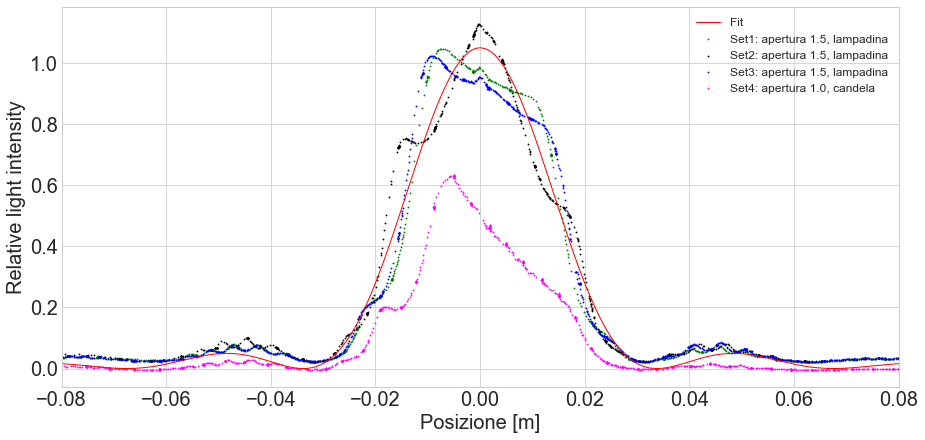

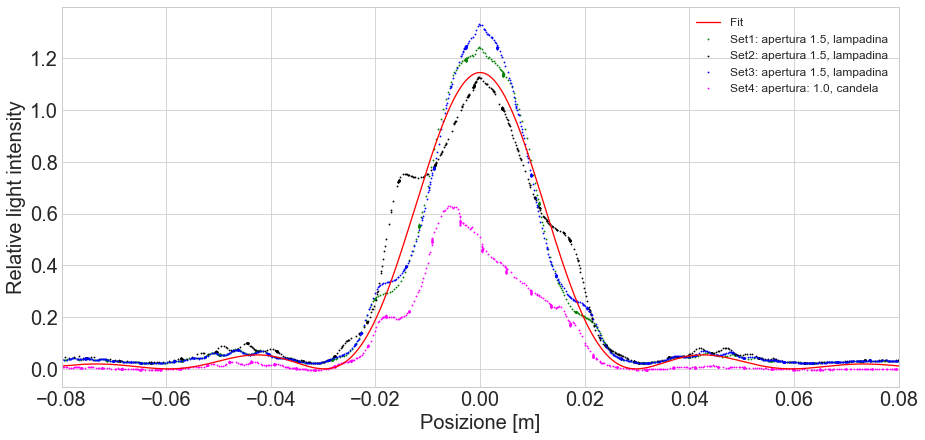

In [13]:
#tolgo già qui gli zeri
#Table1 = d['Antonio_0.02_1.5_lampadina'].loc[((d['Antonio_0.02_1.5_lampadina'].iloc[:,1] != 0) )]
Table2 = d['Antonio_0.02_1.5_lampadina_2'].loc[((d['Antonio_0.02_1.5_lampadina_2'].iloc[:,1] != 0) )]
Table3 = d['Alessio_0.02_1.5_lampadina'].loc[((d['Alessio_0.02_1.5_lampadina'].iloc[:,1] != 0) )]
Table5 = d['Alessandra_0.02_1.5_lampadina'].loc[((d['Alessandra_0.02_1.5_lampadina'].iloc[:,1] != 0) )]
Table4 = d['Alessio_0.02_1.0_candela'].loc[((d['Alessio_0.02_1.0_candela'].iloc[:,1] != 0) )]


#Idata1, xdata1, MaxIntensity, xdataerr, Idataerr1 = preprocessing(Table1, threshold)
Idata2, xdata2, MaxIntensity2, xdataerr2, Idataerr2 = preprocessing(Table2, threshold, manual_adj = -0.0002)
Idata3, xdata3, MaxIntensity3, xdataerr3, Idataerr3 = preprocessing(Table3, threshold, manual_adj = -0.0002)
Idata5, xdata5, MaxIntensity5, xdataerr5, Idataerr5 = preprocessing(Table5, threshold, manual_adj = -0.0002)
Idata4, xdata4, MaxIntensity4, xdataerr4, Idataerr4 = preprocessing(Table4, threshold, manual_adj = -0.005)

#Calcolo stima di a
#est11,est12 = estimate(xdata1, Idata1, grafico = False,manual_sel = [11,25])
est21,est22 = estimate(xdata2, Idata2, grafico = False,manual_sel = [8,24])
est31,est32 = estimate(xdata3, Idata3, grafico = False,manual_sel = [26,8])
est51,est52 = estimate(xdata5, Idata5, grafico = False,manual_sel = [17,5])

a_est_3 = (est21+est31+est51+est22+est32+est52)/6
a_est_err_3 = stdev([est21,est31,est51,est22,est32,est52])*3
print(("a = %g +- %g")%(a_est_3, a_est_err_3))

#Stima intensità massima
MaxIntensity_est = (MaxIntensity2+MaxIntensity3+MaxIntensity5)/3
MaxIntensity_est_err = stdev([MaxIntensity2,MaxIntensity3,MaxIntensity5])*3
print(("MaxIntensity = %g +- %g")%(MaxIntensity_est, MaxIntensity_est_err))


#fit andata
#xfitb1, yfitb1, bfit1, bfiterr1, intensity1, intensity_err_1 = fitting(est11,MaxIntensity_est,xdata1[:1000],Idata1[:1000],Idataerr1[:1000])
#print(("bfit = %g +- %g")%(bfit1, bfiterr1*3))
xfitb2, yfitb2, bfit2, bfiterr2, intensity2, intensity_err_2 = fitting(est21,MaxIntensity_est,xdata2[:1000],Idata2[:1000],Idataerr2[:1000])
print(("bfit = %g +- %g")%(bfit2, bfiterr2*3))
xfitb3, yfitb3, bfit3, bfiterr3, intensity3, intensity_err_3 = fitting(est31,MaxIntensity_est,xdata3[:1500],Idata3[:1500],Idataerr3[:1500])
print(("bfit = %g +- %g")%(bfit3, bfiterr3*3))
xfitb5, yfitb5, bfit5, bfiterr5, intensity5, intensity_err_5 = fitting(est51,MaxIntensity_est,xdata5[:1200],Idata5[:1200],Idataerr5[:1200])
print(("bfit = %g +- %g")%(bfit5, bfiterr5*3))

#fit ritorno
#xfitb1, yfitb1, bfit11, bfiterr11, intensity11, intensity_err_11 = fitting(est12,MaxIntensity_est,xdata1[1000:],Idata1[1000:],Idataerr1[1000:])
#print(("bfit = %g +- %g")%(bfit11, bfiterr11*3))
xfitb2, yfitb2, bfit22, bfiterr22, intensity22, intensity_err_22 = fitting(est22,MaxIntensity_est,xdata2[1000:],Idata2[1000:],Idataerr2[1000:])
print(("bfit = %g +- %g")%(bfit22, bfiterr22*3))
xfitb3, yfitb3, bfit33, bfiterr33, intensity33, intensity_err_33 = fitting(est32,MaxIntensity_est,xdata3[1500:],Idata3[1500:],Idataerr3[1500:])
print(("bfit = %g +- %g")%(bfit33, bfiterr33*3))
xfitb5, yfitb5, bfit55, bfiterr55, intensity55, intensity_err_55 = fitting(est52,MaxIntensity_est,xdata5[1200:],Idata5[1200:],Idataerr5[1200:])
print(("bfit = %g +- %g")%(bfit55, bfiterr55*3))


print('')
b_fit_est_31 = (bfit5+bfit2+bfit3)/3
b_fit_est_err_31 = stdev([bfit2,bfit3,bfit5])*3
b_fit_est_32 = (bfit22+bfit33+bfit55)/3
b_fit_est_err_32 = stdev([bfit22,bfit33,bfit55])*3
int_fit_est_32 = (intensity55+intensity22+intensity33)/3
int_fit_est_err_32 = stdev([intensity55,intensity22,intensity33])*3
int_fit_est_31 = (intensity5+intensity2+intensity3)/3
int_fit_est_err_31 = stdev([intensity5,intensity2,intensity3])*3
print(("-- final estimates for 0.02 (andata):"))
print(("a = %g +- %g")%(b_fit_est_31, b_fit_est_err_31))
print(("max intensity = %g +- %g")%(int_fit_est_31, int_fit_est_err_31))
print(("-- final estimates for 0.02 (ritorno):"))
print(("a = %g +- %g")%(b_fit_est_32, b_fit_est_err_32))
print(("max intensity = %g +- %g")%(int_fit_est_32, int_fit_est_err_32))

xfitb_3 = np.linspace(min(xdata3), max(xdata3), 1000)
yfitb_31 = distanceFunctionFit(xfitb_3,b_fit_est_31,int_fit_est_31)
yfitb_32 = distanceFunctionFit(xfitb_3,b_fit_est_32,int_fit_est_32)

#grafici
fig, ax = plt.subplots(figsize=(15, 7))
plt.scatter(xdata5[:1200],Idata5[:1200],linestyle = "None", color = 'green', s = 0.65, label = 'Set1: apertura 1.5, lampadina');
plt.scatter(xdata2[:1000],Idata2[:1000],linestyle = "None",color= 'black', s = 0.65, label = 'Set2: apertura 1.5, lampadina');
plt.scatter(xdata3[:1500],Idata3[:1500],linestyle = "None", color= 'blue', s = 0.65, label = 'Set3: apertura 1.5, lampadina');
plt.scatter(xdata4[:1300],Idata4[:1300],linestyle = "None", color= 'magenta', s = 0.65, label = 'Set4: apertura 1.0, candela');

plt.plot(xfitb_3,yfitb_31, color = 'red',linewidth=1.0,label = 'Fit')
#plt.plot(np.zeros(len(yfitb_31)),yfitb_31, color = 'red')
plt.xlabel('Posizione [m]', fontsize =20)
ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
plt.legend(loc=1, prop={'size': 12});
plt.ylabel('Relative light intensity', fontsize = 20)
plt.xlim(-0.08, 0.08)
plt.xticks(np.arange(-0.08, 0.09, step=0.02))
plt.show()

fig, ax = plt.subplots(figsize=(15, 7))
plt.scatter(xdata5[1200:],Idata5[1200:],linestyle = "None", color = 'green', s = 0.65, label = 'Set1: apertura 1.5, lampadina');
plt.scatter(xdata2[:1000],Idata2[:1000],linestyle = "None",color= 'black', s = 0.65, label = 'Set2: apertura 1.5, lampadina');
plt.scatter(xdata3[1500:],Idata3[1500:],linestyle = "None", color= 'blue', s = 0.65, label = 'Set3: apertura 1.5, lampadina');
plt.scatter(xdata4[1300:],Idata4[1300:],linestyle = "None", color= 'magenta', s = 0.65, label = 'Set4: apertura: 1.0, candela');

plt.plot(xfitb_3,yfitb_32, color = 'red',linewidth=1.3,label = 'Fit')
#plt.plot(np.zeros(len(yfitb_32)),yfitb_32, color = 'red')
plt.xlabel('Posizione [m]', fontsize =20)
ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
plt.legend(loc=1, prop={'size': 12});
plt.ylabel('Relative light intensity', fontsize = 20)
plt.xlim(-0.08, 0.08)
plt.xticks(np.arange(-0.08, 0.09, step=0.02))
plt.show()

#### Doppia fenditura 0.08 0.5 e 0.04 0.25

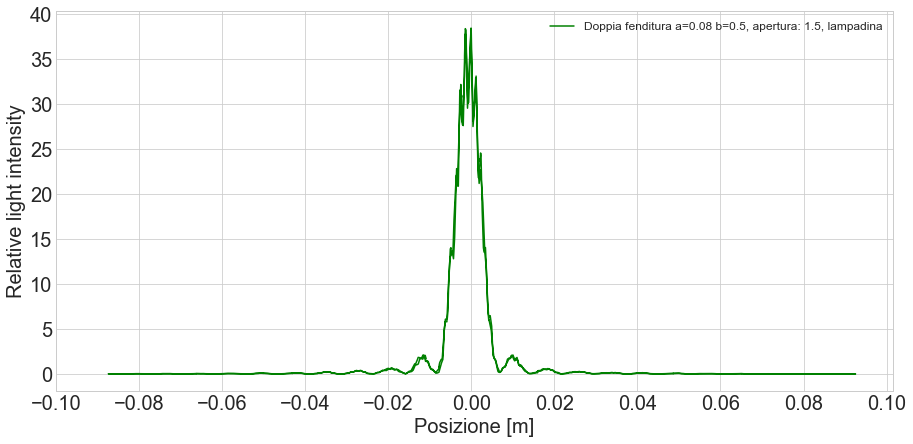

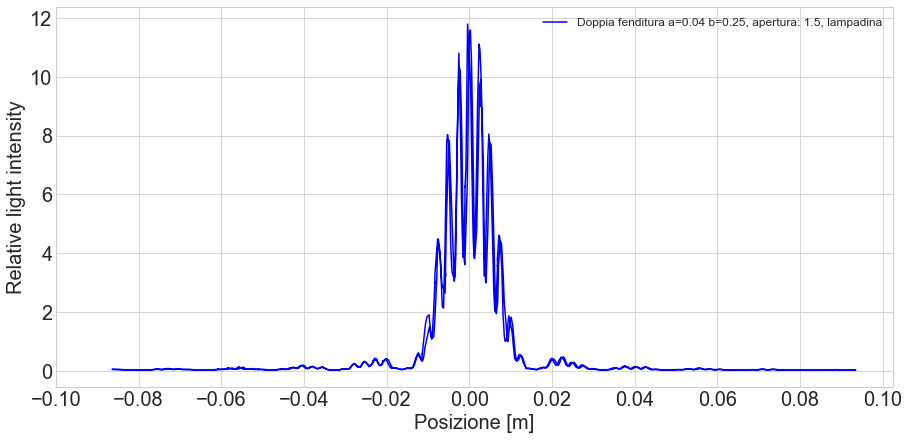

In [14]:
Table1 = d['Alessio_doubleslit_0.08_0.5_1.5_lampadina'].loc[((d['Alessio_doubleslit_0.08_0.5_1.5_lampadina'].iloc[:,1] != 0))]
Idata1, xdata1, MaxIntensity, xdataerr, Idataerr1 = preprocessing(Table1, threshold, manual_adj = 0)

fig, ax = plt.subplots(figsize=(15, 7))
plt.plot(xdata1,Idata1, color = 'green', label = 'Doppia fenditura a=0.08 b=0.5, apertura: 1.5, lampadina');

plt.xlabel('Posizione [m]', fontsize =20)
ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
plt.ylabel('Relative light intensity', fontsize = 20)
plt.legend(loc=1, prop={'size': 12});
plt.xticks(np.arange(-0.10, 0.11, step=0.02))
plt.show()

Table1 = d['Alessio_doubleslit_0.04_0.25_1.5_lampadina'].loc[((d['Alessio_doubleslit_0.04_0.25_1.5_lampadina'].iloc[:,1] != 0))]
Idata1, xdata1, MaxIntensity, xdataerr, Idataerr1 = preprocessing(Table1, threshold, manual_adj = 0)

fig, ax = plt.subplots(figsize=(15, 7))
plt.plot(xdata1,Idata1, color = 'blue',label = 'Doppia fenditura a=0.04 b=0.25, apertura: 1.5, lampadina');

plt.xlabel('Posizione [m]', fontsize =20)
ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
plt.ylabel('Relative light intensity', fontsize = 20)
plt.legend(loc=1, prop={'size': 12});
plt.xticks(np.arange(-0.10, 0.11, step=0.02))
plt.show()